# Goals

1. To be able to implement a simple end-to-end example of Paltas
2. To understand how each of the packages inter-communicate, and which packages need to be run (and when), to perform hierarchichal inference.

# Import Packages

In [15]:
paltas_directory = './'#'/Users/hollowayp/paltas/'
training_directory = '/home/runner/work/notebooks/End_to_End_Tutorial_Files/'
model_directory = '/home/runner/work/notebooks/End_to_End_Tutorial_Files/'
import os
os.chdir(paltas_directory)
from paltas.Analysis import hierarchical_inference,dataset_generation, loss_functions, conv_models
import matplotlib.pyplot as pl
from scipy.stats import norm
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import corner
import emcee
import numba
import h5py
import glob
import sys
random_seed = 4
np.random.seed(random_seed)
tf.random.set_seed(random_seed)


# Generate Images
We start by generating lensed images divided into training and validation sets. The images are saved within one
h5 file for each run of generate.py.

In [2]:
!python3 ./paltas/generate.py ./paltas/Configs/Examples/config_simple_tutorial.py /$training_directory/training/1 --n 1000 --tf_record --h5
!python3 ./paltas/generate.py ./paltas/Configs/Examples/config_simple_tutorial.py /$training_directory/validation/1 --n 1000 --tf_record --h5


2023-08-21 16:31:59.083932: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
Save folder path: .//notebooks/End_to_End_Tutorial_Files//training/1
100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 86.02it/s]
Dataset generation complete. Acceptance rate: 0.992
Saving 1000 files into the tf record
100%|███████████████████████████████████████| 

# Train Model
The neural network is then trained. The --h5 indicates that the images were originally saved as h5 files, and
should be retrieved as such.

In [ ]:
!python3 ./paltas/Analysis/train_model.py ./paltas/Analysis/AnalysisConfigs/train_config_examp_tutorial.py --h5

# Generate Model Predictions
Having trained the model, we locate the filename of the final epoch (this can be hardcoded instead if desired).

In [17]:
def load_model_weights_list(directory):
    """ Function to return a list of weights filenames from the network
    args: Directory containing the training, validation and weights files """
    weights_list = glob.glob(f'{directory}/model_weights/*')
    weights_list = [elem.split('model_weights/')[1] for elem in weights_list]
    return weights_list

def return_final_epoch_weights(directory):
    """ File to return the weight filename of the final trained epoch
    args: Directory containing the training, validation and weights files """
    weights_list = load_model_weights_list(directory)
    print(weights_list)
    final_epoch =  np.max([int(elem.split('-')[0]) for elem in weights_list])
    w_filename = [x for x in weights_list if x.startswith("{:02d}".format(final_epoch)+'-')][0]
    print('FINAL EPOCH',w_filename)
    return directory+'/model_weights/'+w_filename

final_weights_filename = return_final_epoch_weights(model_directory)

['01-4.45.h5', '200--6.28.h5']
FINAL EPOCH 200--6.28.h5


## Configuration
The trained model is loaded (along with the network weights from the final epoch).

In [21]:
def load_model(model_weights_filename,loss_type,model_type,learning_params,log_learning_params,img_size):
    """ Loads the trained model
    args: 
    model_weights_filename (str): .h5 file containing the weights of the trained model.
    loss_type (str): 'full' or 'diag', depending on the type of covariance matrix chosen
    model type (str): 'xresnet34' or 'xresnet101', according to the choice of network
    learning_params (list of str): Parameters learnt by the network
    img_size (int): Dimensions of the input images"""
    num_params = len(learning_params+log_learning_params)
    if loss_type == 'full':
        num_outputs = num_params + int(num_params*(num_params+1)/2)
        loss_func = loss_functions.FullCovarianceLoss(num_params)
    elif loss_type == 'diag':
        num_outputs = 2*num_params
        loss_func = loss_functions.DiagonalCovarianceLoss(num_params)
    if model_type == 'xresnet101':
        model = conv_models.build_xresnet101(img_size,num_outputs)
    if model_type == 'xresnet34':
        model = conv_models.build_xresnet34(img_size,num_outputs)
    model.load_weights(model_weights_filename,by_name=True,skip_mismatch=True)
    return model,loss_func,num_params

#Import training configs
from paltas.Analysis.AnalysisConfigs.train_config_examp_tutorial import learning_params,batch_size,flip_pairs,\
                                                               n_epochs,random_seed,norm_images,\
                                                               loss_function,model_type,\
                                                               npy_folders_train,img_size


corner_param_print= [elem.replace('main_deflector_parameters_','').replace('subhalo_parameters_','')\
                     for elem in learning_params]

model,loss_func,num_params = load_model(final_weights_filename,loss_function,learning_params=learning_params,\
                             log_learning_params=[],model_type=model_type,img_size=img_size)

## Generate Network Predictions
The network predictions are then loaded, for testing on the validation set generated above

In [13]:
def gen_network_predictions(test_folder,norm_path,learning_params,log_learning_params,loss_type,
                            loss_func,model,shuffle=True,
                            norm_images=True,log_norm_images=False):
    """
    Generate neural network predictions given a paltas generated folder of images

    Args:
        test_folder (string): Path to folder of paltas generated images, 
            containig a data.tfrecord file
        norm_path (string): Path to .csv containing normalization of parameters
            applied during training of network
        learning_params (list(string)): Names of parameters learned
        loss_type (string): 'full' or 'diag' currently supported
        loss_func (paltas.Analysis.loss_function): Loss function object, (needs
            draw_samples() and convert_output() functionality)
        model (paltas.Analysis.conv_models): Trained neural network with weights
            loaded
        shuffle (bool, default=True): If True, the order of the test set is shuffled
            when generating predictions
        norm_images (bool, default=True): If True, normalize test set images
        log_norm_images (bool, default=False): If True, test set imags are
            log-normalized and rescaled to range (0,1)

    Returns:
        y_test, y_pred, std_pred, prec_pred
    """

    tfr_test_path = os.path.join(test_folder,'data.tfrecord')
    input_norm_path = norm_path

    if loss_type not in {'full','diag'}:
        raise ValueError('loss_type not supported')
    tf_dataset_test = dataset_generation.generate_tf_dataset(tf_record_path = tfr_test_path,\
                                                             learning_params = learning_params,
                                                             batch_size = 3,\
                                                             n_epochs = 1,\
                                                             norm_images=norm_images,
                                                             kwargs_detector=None,\
                                                             input_norm_path=input_norm_path,
                                                             log_learning_params=log_learning_params,\
                                                             shuffle=shuffle)

    y_test_list = [];y_pred_list = []
    std_pred_list = [];cov_pred_list = []
    predict_samps_list = []

    for batch in tf_dataset_test:
        images = batch[0].numpy()
        y_test = batch[1].numpy()
        
        # use unrotated output for covariance matrix
        output = model.predict(images)

        if loss_type == 'full':
            y_pred, precision_matrix, _ = loss_func.convert_output(output)
        else:
            y_pred, log_var_pred = loss_func.convert_output(output)

        # compute std. dev.
        if loss_type == 'full':
            cov_mat = np.linalg.inv(precision_matrix.numpy())
            std_pred = np.zeros((cov_mat.shape[0],cov_mat.shape[1]))
            for i in range(len(std_pred)):
                std_pred[i] = np.sqrt(np.diag(cov_mat[i]))
            
        else:
            std_pred = np.exp(log_var_pred/2)
            cov_mat = np.empty((len(std_pred),len(std_pred[0]),len(std_pred[0])))
            for i in range(len(std_pred)):
                cov_mat[i] = np.diag(std_pred[i]**2)

        y_test_list.append(y_test)
        y_pred_list.append(y_pred)
        std_pred_list.append(std_pred)
        cov_pred_list.append(cov_mat)

    y_test = np.concatenate(y_test_list)
    y_pred = np.concatenate(y_pred_list)
    std_pred = np.concatenate(std_pred_list)
    cov_pred = np.concatenate(cov_pred_list)

    if input_norm_path is not None:
        dataset_generation.unnormalize_outputs(input_norm_path,learning_params+log_learning_params,
                                        y_pred,standard_dev=std_pred,cov_mat=cov_pred)
        dataset_generation.unnormalize_outputs(input_norm_path,learning_params+log_learning_params,
                                        y_test)
    prec_pred = np.linalg.inv(cov_pred)
   
    return y_test, y_pred, std_pred, prec_pred

In [22]:
network_predictions = gen_network_predictions(\
                        test_folder=training_directory+'/validation/1',\
                        norm_path=training_directory+'/training/1/norms.csv',\
                        learning_params=learning_params,\
                        log_learning_params = [],\
                        loss_type=loss_function,
                        loss_func=loss_func,\
                        model=model,shuffle=True,
                        norm_images=norm_images,log_norm_images=False)

/Users/hollowayp/paltas/paltas/Analysis/dataset_generation.py:278: UserWarning: No noise will be added
  warnings.warn('No noise will be added')


1/1 [==============================] - 0s 32ms/step


## Plot Network Output Distributions
We now plot the distributions of the network predictions, and compare those to the ground-truth

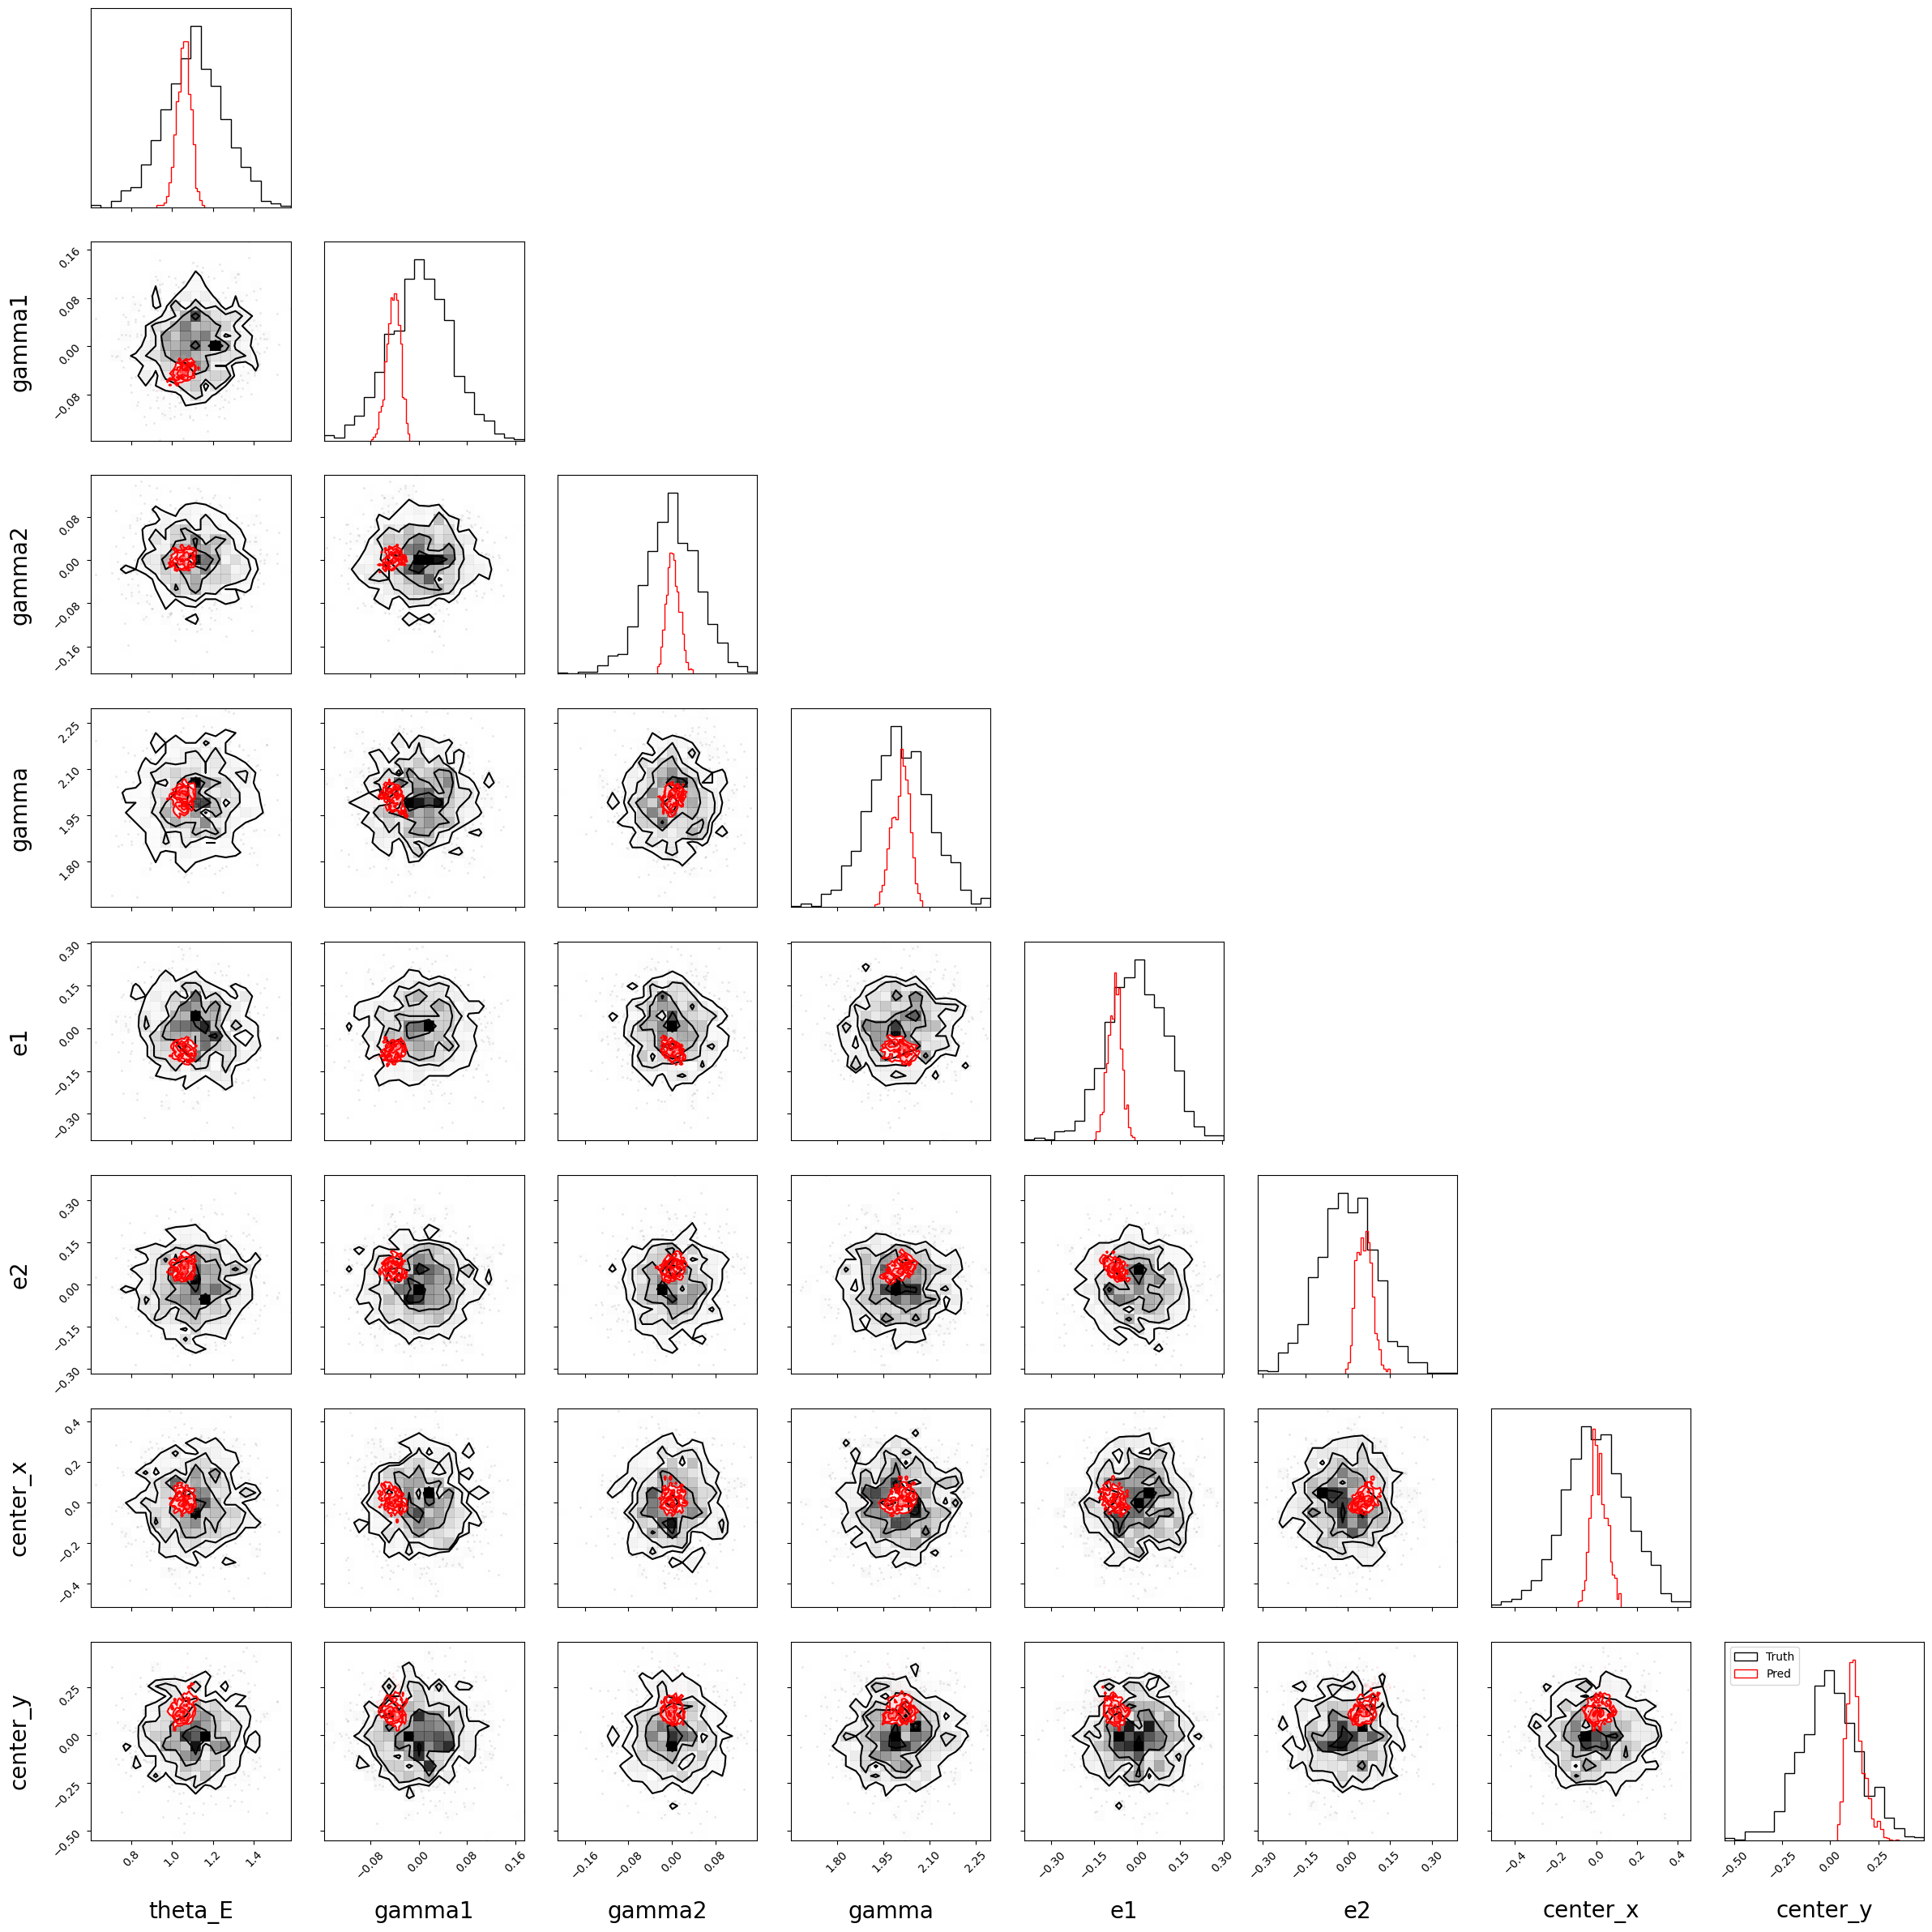

In [23]:
label_kwargs = {'fontsize': 20}
fig = pl.figure(figsize=(3*len(learning_params),3*len(learning_params)))
corner.corner(network_predictions[0],fig=fig,color='k')
corner.corner(network_predictions[1],fig=fig,color='red',\
              labels=corner_param_print,\
              label_kwargs=label_kwargs)
pl.legend(['Truth','Pred'])
pl.tight_layout()
pl.show()

## Load Model Outputs
The hyperparameters of the training set are loaded (to use as an interim prior in the hierarchical inference), along with the network predictions for the validation set

In [25]:
train_mean = np.array(pd.read_csv(training_directory+'/training/1/norms.csv')['mean']) 
train_scatter = np.array(pd.read_csv(training_directory+'/training/1/norms.csv')['std']) 

#Since we are using a diagonal covariance matrix, the precision matrix is the diagonal matrix of
#the (elementwise) values of 1/std^2. In general however it is inv(cov_matrix).
network_means = network_predictions[1][:,:].astype('float64')              
network_prec = network_predictions[3][:,:,:].astype('float64')

# Hierarchical Inference
The following performs hierarchical inference to retrieve the population hyperparameters of the validation set, assuming a diagonal covariance matrix.

In [27]:
def hierarchical_inference_func(n_lenses,y_pred,prec_pred,train_mean,train_scatter,n_param=None,n_samps = 1e+4):
    """
    Returns:
        sampler object
    """
    # Load the predictions for the mean and covariance for our model. We'll have to do a little reshaping here since the code
    # expect an array of mean values and a precision matrix.
    y_pred_hi = y_pred
    prec_pred_hi = prec_pred
    # The interim training distribution.
    mu_omega_i = np.array(train_mean)
    cov_omega_i = np.diag(np.array(train_scatter)**2)
    if n_param is None: ndim =2*num_params
    else: ndim = 2*n_param
    # uniform prior with bounds
    @numba.njit()
    def eval_func_omega(hyperparameters):
        # log prior for uniform in sigma space, as opposed to uniform in log space
        return 0#np.sum(hyperparameters[int(ndim/2):])

    # Initialize our class and then give it the network predictions. These are set to global variables in case you want to use
    # pooling.
    prob_class = hierarchical_inference.ProbabilityClassAnalytical(mu_omega_i,cov_omega_i,eval_func_omega)
    prob_class.set_predictions(mu_pred_array_input=y_pred_hi,prec_pred_array_input=prec_pred_hi)

    # Set a few of the parameters we will need to pass to emcee
    n_walkers = 40
    # Generate an initial state informed by prior range
    cur_state_mu = np.concatenate([np.random.uniform(low=-5,high=5,size=(n_walkers,1))\
                                   for i in range(int(ndim/2))],axis=1)
    cur_state_sigmas = np.log(np.concatenate([np.random.uniform(low=0.01,high=0.01,size=(n_walkers,1))\
                                   for i in range(int(ndim/2))],axis=1))
    cur_state = np.concatenate((cur_state_mu,cur_state_sigmas),axis=1)
    sampler = emcee.EnsembleSampler(n_walkers, ndim,prob_class.log_post_omega)
    _ = sampler.run_mcmc(cur_state,n_samps,progress=True,skip_initial_state_check=True)
 
    return sampler

In [29]:
burnin = int(10)

sampler = hierarchical_inference_func(1000,network_means,network_prec,\
                      train_mean[:].astype('float64'),train_scatter[:].astype('float64'),n_samps=100)
chain = sampler.chain[:,burnin:,:].reshape((-1,2*num_params))[:,0:num_params] #Just using the means for now

100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


# Results
We plot the results of the hierarchical inference here: the ground-truth is plotted as solid black lines, along with the population posterior 

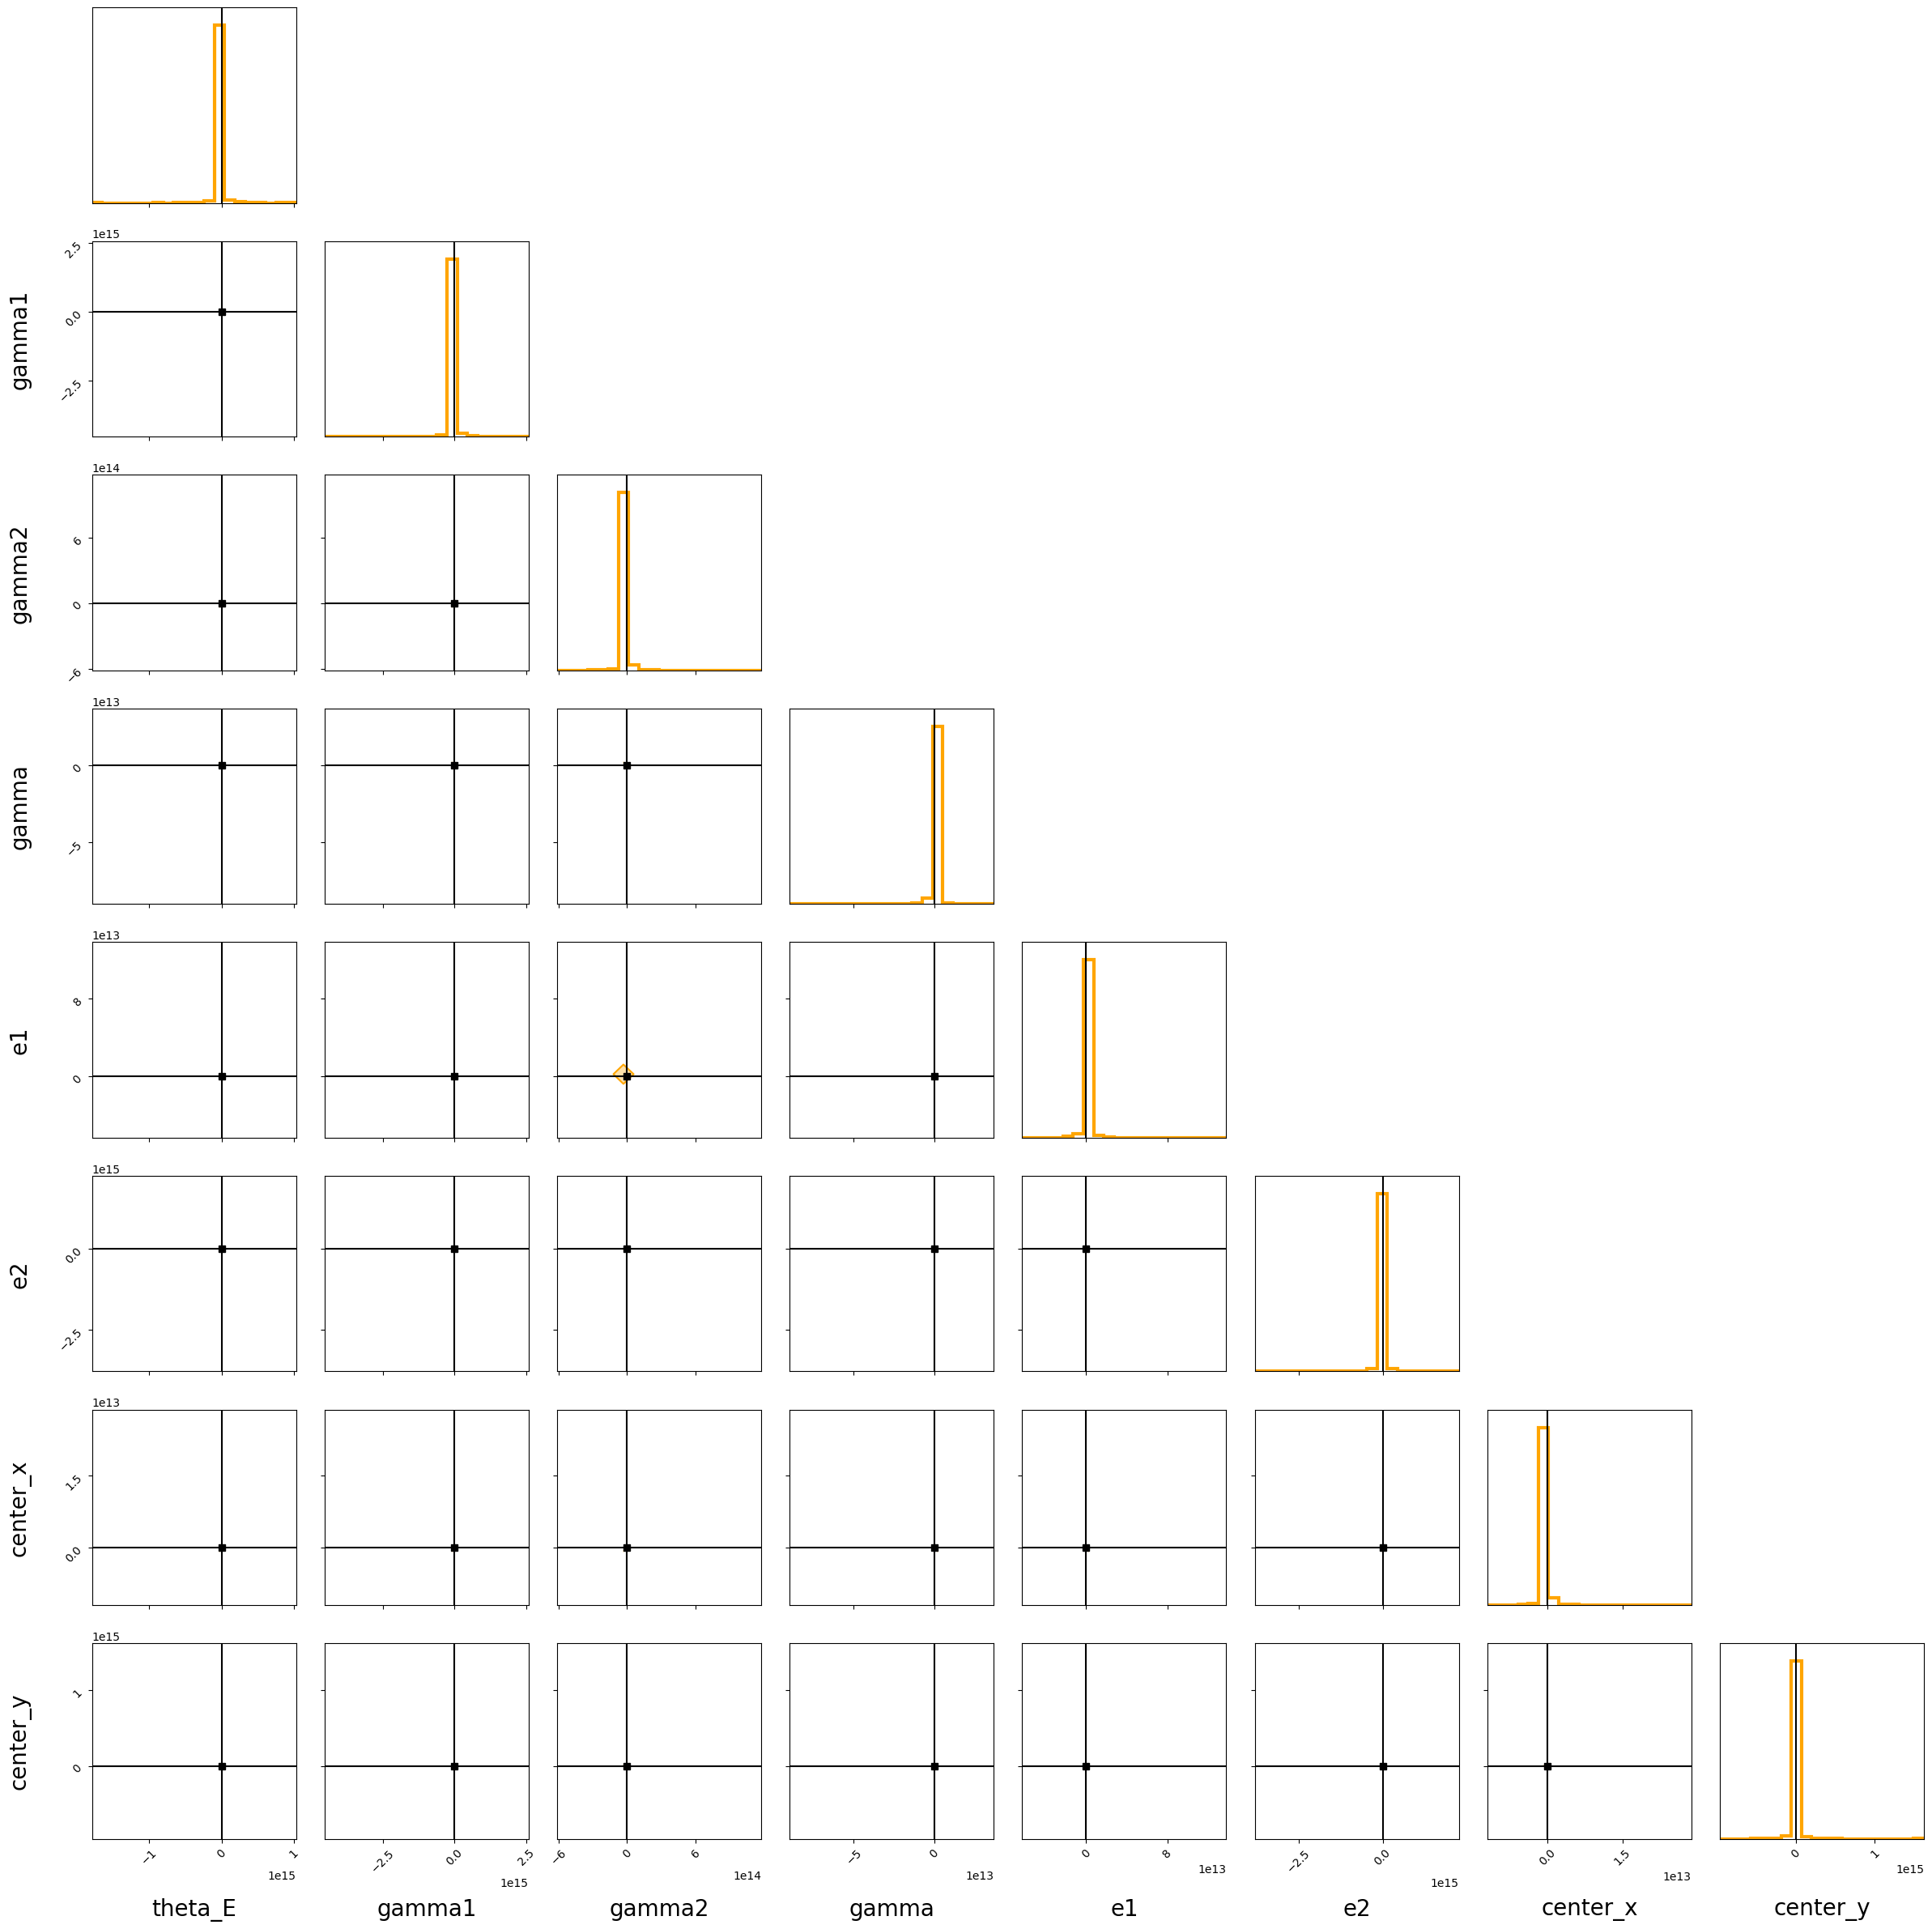

In [32]:
labels_kwargs = {'fontsize':20}
hist_kwargs = {'density':True,'color':'orange','lw':3}
fig = pl.figure(figsize=(3*len(learning_params),3*len(learning_params)))
corner.corner(chain,labels=corner_param_print,fig=fig,show_titles=False,plot_datapoints=False,\
              label_kwargs=labels_kwargs,\
              levels=[0.68,0.95],color='orange',fill_contours=True,hist_kwargs=hist_kwargs,title_fmt='.2f',\
              truths=[1.1,0,0,2,0,0,0,0],truth_color='k',\
              max_n_ticks=3,bins=20)

pl.tight_layout()
pl.show()